stopwords - Stopwords add extra words without adding significant meaning, so removing them can improve focus on the actual content.
Improve Efficiency: By reducing the number of words, it saves computational resources.
Enhance Model Performance: Many models perform better when trained on more meaningful words, leading to improved text classification, sentiment analysis, and other NLP tasks.

For example, in our movie recommendation project, removing stopwords from descriptions allows the emotion detection model to focus on significant words that represent the underlying emotions.

In [1]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from nltk.corpus import stopwords

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
df = pd.read_csv("/content/netflix_titles.csv")

     show_id     type                  title         director  \
0         s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1         s2  TV Show          Blood & Water              NaN   
2         s3  TV Show              Ganglands  Julien Leclercq   
3         s4  TV Show  Jailbirds New Orleans              NaN   
4         s5  TV Show           Kota Factory              NaN   
...      ...      ...                    ...              ...   
8802   s8803    Movie                 Zodiac    David Fincher   
8803   s8804  TV Show            Zombie Dumb              NaN   
8804   s8805    Movie             Zombieland  Ruben Fleischer   
8805   s8806    Movie                   Zoom     Peter Hewitt   
8806   s8807    Movie                 Zubaan      Mozez Singh   

                                                   cast        country  \
0                                                   NaN  United States   
1     Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa 

In [5]:
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [6]:
print("\nFirst few rows of the dataset:")
print(df.head())


First few rows of the dataset:
  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons 

In [7]:
# Check for missing values in each column
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64


In [8]:
# Fill missing values for columns with high numbers of NaNs
df['director'].fillna("Unknown", inplace=True)
df['cast'].fillna("Unknown", inplace=True)
df['country'].fillna("Unknown", inplace=True)

# For columns with few missing values, drop rows
df.dropna(subset=['date_added', 'rating', 'duration'], inplace=True)

# Reset the index after dropping rows
df.reset_index(drop=True, inplace=True)

# Confirm that there are no more missing values
print("\nMissing values after handling:")
print(df.isnull().sum())


Missing values after handling:
show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64


<ipython-input-8-49b88413a3c5>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['director'].fillna("Unknown", inplace=True)
<ipython-input-8-49b88413a3c5>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

In [9]:
# # Drop any duplicate descriptions
# df = df.drop_duplicates(subset='description').reset_index(drop=True)

In [10]:
# Summary statistics for description length (useful for understanding text length)
df['description_length'] = df['description'].apply(len)
print("\nDescription Length Statistics:")
print(df['description_length'].describe())


Description Length Statistics:
count    8758.000000
mean      143.293103
std        10.347886
min        61.000000
25%       140.000000
50%       146.000000
75%       149.000000
max       248.000000
Name: description_length, dtype: float64


In [ ]:
"""
   Step-1: Convert all text to lowercase.
           Remove special characters and punctuation.
           Remove extra whitespace.
   Step-2: Apply the cleaning function to the 'description' column.
           The 'clean_text' function is applied to each entry in the 'description' column of the dataframe,
           creating new column called 'cleaned_description' containing the processed text.
   Step-3: Remove stop words from the 'cleaned_description' column.
   Step-4: Display and save the cleaned data.

"""
# Data Cleaning Function
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

    # Apply cleaning function to the 'description' column
df['cleaned_description'] = df['description'].apply(clean_text)
# Remove stop words
stop_words = set(stopwords.words('english'))
df['cleaned_description'] = df['cleaned_description'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in stop_words])
)
# Display cleaned data
print("\nCleaned Descriptions (first few rows):")
print(df[['description', 'cleaned_description']].head())

# Save the cleaned data to a new CSV
df.to_csv("/content/netflix_cd.csv", index=False)

In [ ]:
from huggingface_hub import login

# Log in to Hugging Face
login()

For example, if 'batch_size' is 16 and 'descriptions' has 100 items, the slices in each iteration would look like this:

First iteration: descriptions[0:16] (items 0 to 15)
Second iteration: descriptions[16:32] (items 16 to 31)
Third iteration: descriptions[32:48] (items 32 to 47)
And so on, until all descriptions are processed.
This approach is an efficient way to handle data in chunks instead of processing the entire list at once.

outputs.logits:
This is the output from the model, containing the raw prediction scores (logits) for each class for each input sample in the batch.
Each row in outputs.logits corresponds to a sample, and each column represents the score (logit) for a particular class.

dim=1:
This specifies the dimension along which torch.argmax will search for the highest value.
dim=1 means we’re looking for the index of the highest score across the columns (classes) for each row (sample).

In [3]:
"""
   Step-1: Define the 'predict_emotions_batch' function where function takes in a list of descriptions and batch size.
           It initialize empty list 'predictions'
   Step-2: Iterate through the descriptions in batches.
           batch processing: The function processes description in batches to handle a limited number at a time,
           optimizing memory use and processing speed.
           i:i+batch_size selects a subset of description for each iteration, creating a 'batch'.
   Step-3: Tokenization: 'tokenizer' converts each text in the batch to a format the model can undersatnd, padding and
           truncating to a maximum length of 512 tokens.
           return_tensors = "pt" specifies that the output will be in PyTorch tensor format.
           truncation = True ensures texts longer than the max length are truncated,
           padding=True adds padding for shorter texts.
   Step-4: Predictions without gradient calculations
           no gradient calculation - torch.no_grad() temporarily disables gradient tracking to save memory and speed up
           up the computation, as were only making predicions and not training the model.
           'outputs' - having raw prediction scores for each emotion class.
   Step-5: Identify predicted classes
           'torch.argmax' identifies the index of the highes score(emotion class) in the logits for each description in the batch.
           'predicted_class_indices' is converted to a numpy array and added to the the 'predictions' list.
   Step-6:  Return the list of predicted classes.
"""

# Load your dataset
df = pd.read_csv('/content/netflix_cd.csv')  # Ensure your dataset is loaded here

# # Load the GoEmotions model and tokenizer
# model_name = "yjernite/bert-base-uncased-go-emotions"  # GoEmotions model
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name)

model_name = "bhadresh-savani/bert-base-uncased-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Set device to CPU
device = 'cpu'
model.to(device)

# Function to predict emotions for a batch of descriptions
def predict_emotions_batch(descriptions, batch_size=16):
    predictions = []

    for i in range(0, len(descriptions), batch_size):
        batch = descriptions[i:i + batch_size]

        # Tokenize the input descriptions
        inputs = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = inputs.to(device)  # Move to CPU

        with torch.no_grad():
            outputs = model(**inputs)

        # Get the predicted class indices for all descriptions
        predicted_class_indices = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        predictions.extend(predicted_class_indices)

    return predictions

# Prepare a list of cleaned descriptions from the DataFrame
cleaned_descriptions = df['cleaned_description'].tolist()

# Make predictions for the entire dataset
predicted_emotions = predict_emotions_batch(cleaned_descriptions)

# Add the predictions to the DataFrame
df['predicted_emotion'] = predicted_emotions

# Display the DataFrame with the new predictions column
print("\nDataFrame with Predicted Emotions:")
print(df[['description', 'cleaned_description', 'predicted_emotion']].head())

# Optional: Save the updated DataFrame with predictions to a new CSV
df.to_csv("/content/netflix_titles_with_predictions.csv", index=False)

tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/935 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]


DataFrame with Predicted Emotions:
                                         description  \
0  As her father nears the end of his life, filmm...   
1  After crossing paths at a party, a Cape Town t...   
2  To protect his family from a powerful drug lor...   
3  Feuds, flirtations and toilet talk go down amo...   
4  In a city of coaching centers known to train I...   

                                 cleaned_description  predicted_emotion  
0  father nears end life filmmaker kirsten johnso...                  1  
1  crossing paths party cape town teen sets prove...                  4  
2  protect family powerful drug lord skilled thie...                  3  
3  feuds flirtations toilet talk go among incarce...                  3  
4  city coaching centers known train indias fines...                  2  


In [12]:
updated_df = pd.read_csv('/content/netflix_titles_with_predictions.csv')
print(updated_df.head())

  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water          Unknown   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans          Unknown   
4      s5  TV Show           Kota Factory          Unknown   

                                                cast        country  \
0                                            Unknown  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...        Unknown   
3                                            Unknown        Unknown   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021        

In [13]:
print(updated_df['predicted_emotion'].value_counts())

predicted_emotion
1    3697
3    2366
4    1421
0     868
2     340
5      66
Name: count, dtype: int64


In [14]:
# Define the mapping from numerical labels to emotion names
emotion_labels = {
    0: 'anger',
    1: 'joy',
    2: 'sadness',
    3: 'fear',
    4: 'surprise',
    5: 'disgust'
}

# Map the predicted emotions to their labels
updated_df['predicted_emotion'] = updated_df['predicted_emotion'].map(emotion_labels)

# Display the updated counts
print(updated_df['predicted_emotion'].value_counts())

predicted_emotion
joy         3697
fear        2366
surprise    1421
anger        868
sadness      340
disgust       66
Name: count, dtype: int64


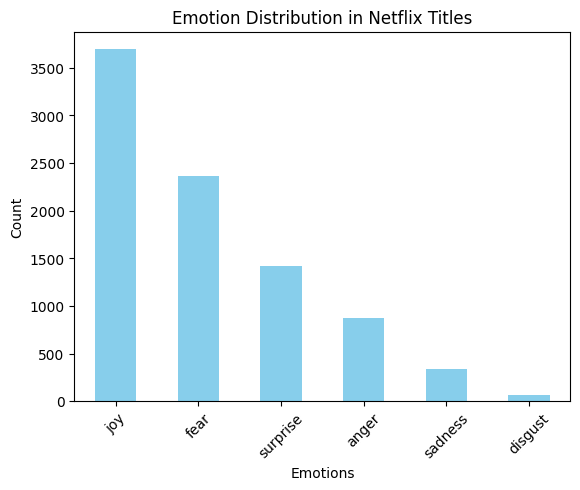

In [17]:
# Visualize the distribution of emotions
emotion_counts = updated_df['predicted_emotion'].value_counts()
emotion_counts.plot(kind='bar', color='skyblue')
plt.title('Emotion Distribution in Netflix Titles')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [21]:
def recommend_by_emotion(emotion, df, num_recommendations=5):
    recommendations = df[df['predicted_emotion'] == emotion].sample(n=num_recommendations)
    return recommendations[['title', 'description']]

# Get recommendations for 'anger'
joy_recommendations = recommend_by_emotion('anger', updated_df)
print("\nRecommended Titles for Anger:")
print(joy_recommendations)


Recommended Titles for Anger:
                                      title  \
1662         If Anything Happens I Love You   
5878  Cowspiracy: The Sustainability Secret   
3208                           Holiday Rush   
1356                            Total Drama   
7803                              Red Trees   

                                            description  
1662  Grieving parents journey through an emotional ...  
5878  Learn how factory farming is decimating the pl...  
3208  A widowed radio DJ and his four spoiled kids n...  
1356  Heartwarming moments are interspersed with bac...  
7803  A documentarian details her Jewish family's es...  
